In [1]:
import sys
import numpy as np
import time
from numpy import ndarray
from numpy.linalg import norm
from skimage.io import imread
import matplotlib.pyplot as plt
from numba import njit
from sklearn.mixture import GaussianMixture
from diffusion import *

In [2]:
@njit
def get_neighbours(height,width,i,j):

    '''
    Parameters
        height: int
            height of input image 
        width: int
            width of input image 
        i: int
            number of row
        j: int
            number of column
    Returns
        N: tuple
            neighbours coordinates, neighbours indices, inverse neighbours indices
    calculates neighbours in 4-neighbours system (and inverse indices)
    
    
             (i-1,j-1)  (i-1,j)  (i-1,j+1) 
                      \    |    /
                       \   |   /
                        \  |  /
                (i,j-1)--(i,j)--(i,j+1)
                        /  |  \
                       /   |   \
                      /    |    \
             (i+1,j-1)  (i+1,j)  (i+1,j+1)
    '''

    # i,j - position of pixel
    # [Left, Right, Up, Down] - order of possible neighbours
    # array of neighbour indices

    nbs = []
    # neighbour indices
    nbs_indices = []
    # inverse neighbour indices
    inv_nbs_indices = []
    # Top Left
    if 0<=i-1<height-1 and 0<=j-1<width-1:
        nbs.append([i-1,j-1])
        inv_nbs_indices.append(7)
        nbs_indices.append(0)
        
    # Top Up
    if 0<=i-1<height-1 and 0<=j<=width-1:
        nbs.append([i-1,j])
        inv_nbs_indices.append(6)
        nbs_indices.append(1)        

    # Top Right
    if 0<=i-1<height-1 and 0<j+1<=width-1:
        nbs.append([i-1,j+1])
        inv_nbs_indices.append(5)
        nbs_indices.append(2)
    # Left
    if 0<=i<=height-1 and 0<=j-1<width-1:
        nbs.append([i,j-1])
        inv_nbs_indices.append(4)
        nbs_indices.append(3)
    # Right
    if 0<=i<=height-1 and 0<j+1<=width-1:
        nbs.append([i,j+1])
        inv_nbs_indices.append(3)
        nbs_indices.append(4)
    # Bottom Left
    if 0<i+1<=height-1 and 0<=j-1<width-1:
        nbs.append([i+1,j-1])
        inv_nbs_indices.append(2)
        nbs_indices.append(5)
    # Bottom Down
    if 0<i+1<=height-1 and 0<=j<=width-1:
        nbs.append([i+1,j])
        inv_nbs_indices.append(1)
        nbs_indices.append(6)
    # Bottom Right
    if 0<i+1<=height-1 and 0<j+1<=width-1:
        nbs.append([i+1,j+1])
        inv_nbs_indices.append(0)
        nbs_indices.append(7)
    
    N = (nbs, inv_nbs_indices, nbs_indices)
    return N

In [3]:
@njit
def get_right_down(height,width,i,j):
    # i,j - position of pixel
    # [Right, Down] - order of possible neighbours
    # array of neighbour indices
    nbs = [] 
    # neighbour indices
    nbs_indices = []
    # inverse neighbour indices
    inv_nbs_indices = []
    # Right
    if 0<=i<=height-1 and 0<j+1<=width-1:
        nbs.append([i,j+1])
        inv_nbs_indices.append(3)
        nbs_indices.append(4)
    # Bottom Down
    if 0<i+1<=height-1 and 0<=j<=width-1:
        nbs.append([i+1,j])
        inv_nbs_indices.append(1)
        nbs_indices.append(6)
    # Bottom Right
    if 0<i+1<=height-1 and 0<j+1<=width-1:
        nbs.append([i+1,j+1])
        inv_nbs_indices.append(0)
        nbs_indices.append(7)
    N = (nbs, inv_nbs_indices, nbs_indices)
    return N

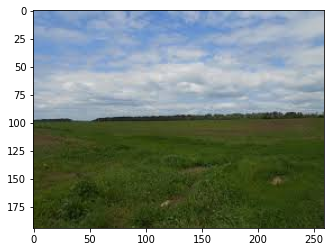

In [4]:
img = imread("image.png").astype(int)[...,:3]
plt.imshow(img)

In [5]:
height, width, _ = img.shape
K = np.arange(3)
n_labels = len(K)
beta = 15

In [6]:
permitted_edges = [
        [[0],[0],[0],[0,1],[0,1],[0,1],[0,1],[0,1]], # from first label to every label of neighbour
        [[0,1],[0],[0,1],[0,1,2],[0,1,2],[1,2],[2],[1,2]],  # from second label to every label of neighbour
        [[1,2],[1,2],[1,2],[1,2],[1,2],[2],[2],[2]] # from third label to every label of neighbour
    ]

In [7]:
#@njit
def get_g(height,width,n_labels,beta,permitted_edges):
    g = np.full((height,width,8,n_labels,n_labels),-np.inf)
    for i in range(height):
        for j in range(width):
            _, _, neighbours_ind = get_neighbours(height,width,i,j)
            for n in neighbours_ind:
                for k in range(n_labels):
                    for k1 in permitted_edges[k][n]:
                        g[i,j,n,k,k1] = -beta*(k != k1)
    return g

In [8]:
g = get_g(height,width,n_labels,beta,permitted_edges)

In [9]:
shift_x_left = int(width*0.3)
shift_x_right = -int(width*0.3)
shift_y_top = int(height*0.05)
shift_y_bottom = int(height*0.15)

segment_up = img[shift_y_top:shift_y_bottom,shift_x_left:shift_x_right].reshape(-1,3)
segment_bottom = img[height - shift_y_bottom:height - shift_y_top,shift_x_left:shift_x_right].reshape(-1,3)

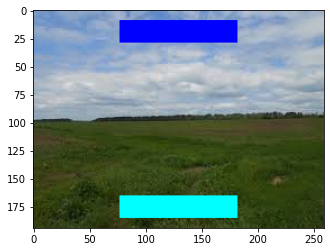

In [10]:
img_v = img.copy()
img_v[shift_y_top:shift_y_bottom,shift_x_left:shift_x_right] = [0,0,255]
img_v[height - shift_y_bottom:height - shift_y_top,shift_x_left:shift_x_right] = [0,255,255]
plt.imshow(img_v)

In [11]:
gm_up = GaussianMixture(n_components=1, random_state=0).fit(segment_up)
gm_bottom = GaussianMixture(n_components=1, random_state=0).fit(segment_bottom)

In [12]:
det_cov_up = np.linalg.det(gm_up.covariances_[0])
det_cov_bottom = np.linalg.det(gm_bottom.covariances_[0])

gm_border_covariances = (gm_up.covariances_[0] + gm_bottom.covariances_[0])/2
det_cov_border = (det_cov_up + det_cov_bottom)/2
gm_border_means_ = (gm_up.means_+ gm_bottom.means_)/2


covs = np.array([gm_up.covariances_[0], gm_border_covariances,  gm_bottom.covariances_[0]])
det_covs = np.array([det_cov_up, det_cov_border,  det_cov_bottom])
means = np.array([gm_up.means_, gm_border_means_,gm_bottom.means_])

In [13]:
Q = np.zeros((height,width,n_labels))
a = (-5/2)*np.log(2*np.pi) - (1/2)*np.log(det_covs).reshape(3,1,1) 
b = np.linalg.inv(covs)

for i in range(height):
    for j in range(width):
        Q[i,j,:] =    (a  - (1/2)*(img[i,j,:] - means)@b@( (img[i,j,:] - means).reshape(3,-1,1)))[:,0,0]

In [24]:
a = time.time()
fi = diffusion(height, width, np.arange(3), Q, g, 100)
# get optimal labelling
labelling = get_labelling(height, width, g, fi)
print(time.time()-a)

20.895792484283447


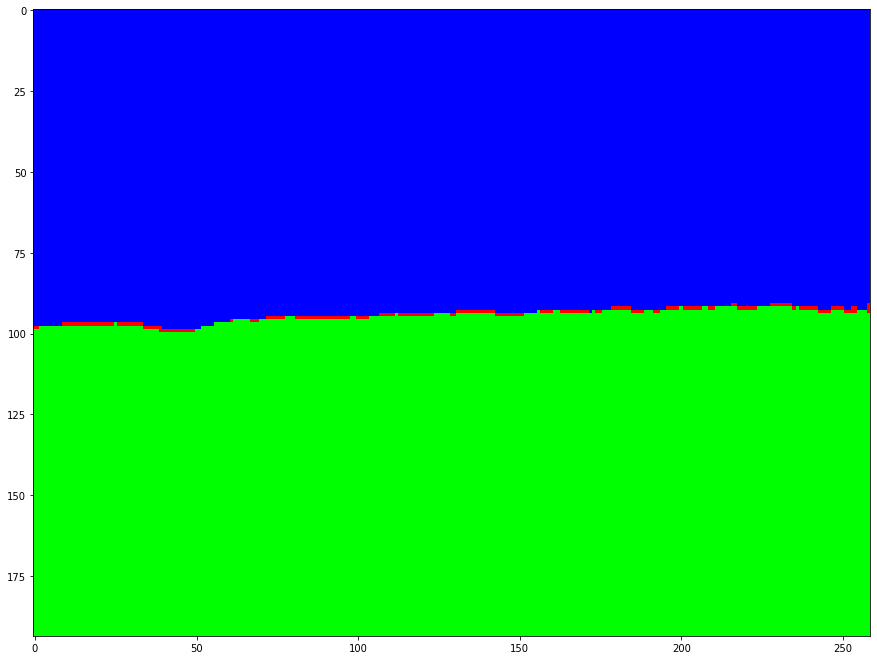

In [25]:
plt.figure(figsize=(15,15))
plt.imshow(labelling)

In [31]:
@njit
def get_reparametrized_g(g,fi):
    g_reparametrized = np.full_like(g, -np.inf)
    eps_array = np.zeros_like(g)
    for i in range(height):
        for j in range(width):
            nbs, inv_nbs_indices, nbs_indices = get_neighbours(height,width,i,j)
            for n,[n_i,n_j] in enumerate(nbs):
                # calculating reparametrized binary penalties
                g_reparametrized[i,j,nbs_indices[n],:] = g[i,j,nbs_indices[n],:] - fi[i,j,nbs_indices[n],:] - fi[n_i,n_j,inv_nbs_indices[n],:]
                g_max = np.max(g_reparametrized[i,j,nbs_indices[n],:])
                eps_array[i,j,nbs_indices[n],:] = np.abs(g_max - g_reparametrized[i,j,nbs_indices[n],:])
    eps_unique = np.unique(eps_array)
    return g_reparametrized, eps_unique

In [32]:
g_reparametrized, eps_array  = get_reparametrized_g(g,fi)

In [33]:
eps_array.max()

inf

array([0.00000000e+00, 2.23689990e-02, 9.03399699e-02, ...,
       1.27408470e+03, 1.27453220e+03,            inf])

In [69]:
g_binary = np.full_like(g, 0)
for i in range(height):
    for j in range(width):
        nbs, inv_nbs_indices, nbs_indices = get_neighbours(height,width,i,j)
        for n,[n_i,n_j] in enumerate(nbs):
                g_max = np.max(g_reparametrized[i,j,nbs_indices[n],:])
                g_binary[i,j,nbs_indices[n],:] = (np.abs(g_max - g_reparametrized[i,j,nbs_indices[n],:]) <=500)

In [70]:
@njit
def crossing_out(g,g_binary,q_binary):
    change_indicator = True
    while (change_indicator):
        change_indicator = False
        for i in range(height):
            for j in range(width):
                nbs, inv_nbs_indices, nbs_indices = get_neighbours(height,width,i,j)
                for k in range(n_labels):
                    if q_binary[i,j,k] == 0:
                        for n,[n_i,n_j] in enumerate(nbs):
                            for n_k in range(n_labels):
                                # edge exists
                                if g_binary[i,j,nbs_indices[n],k,n_k] == 1 and g[i,j,nbs_indices[n],k,n_k] != -10**8:
                                    g_binary[i,j,nbs_indices[n],k,n_k] = False
                                    g_binary[n_i,n_j,inv_nbs_indices[n],n_k,k] = False
                                    change_indicator = True
                    # `if` ends
                    for n,[n_i,n_j] in enumerate(nbs):
                        edge_exist = False
                        for n_k in range(n_labels):
                            if g_binary[i,j,nbs_indices[n],k,n_k] == 1 and g[i,j,nbs_indices[n],k,n_k] != -10**8:
                                edge_exist = True
                                break
                        if edge_exist == 0 and q_binary[i,j,k]==1:
                            q_binary[i,j,k] = 0
                            change_indicator = True
    return q_binary

In [71]:
q_binary = np.ones_like(Q)
q_binary = crossing_out(g,g_binary,q_binary)

In [72]:
(q_binary == 0).all()

True

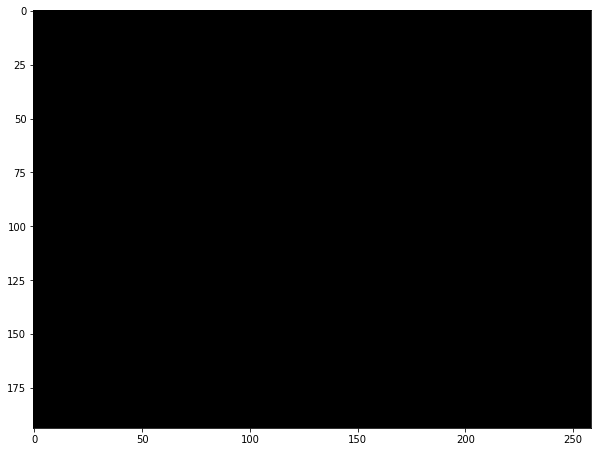

In [73]:
plt.figure(figsize=(10,10))
plt.imshow(q_binary)

In [74]:
some_shit = np.zeros((height,width))
for i in range(height-1):
    for j in range(width-1):
        nbs, inv_nbs_indices, nbs_indices = get_right_down(height,width,i,j)
        n = nbs_indices[0]
        n_i, n_j = nbs[0]
        for k in range(n_labels):
            for k1 in range(n_labels):
                if q_binary[i,j,k] == 1 and g_binary[i,j,n,k,k1]==1 and q_binary[n_i,n_j,k1]==1:
                    some_shit[i,j] = k

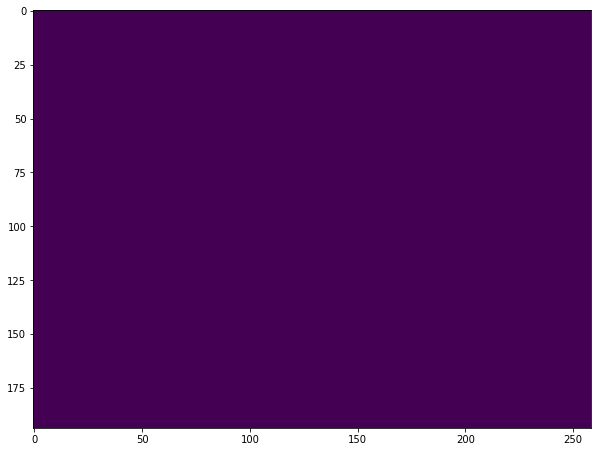

In [75]:
plt.figure(figsize= (10,10))
plt.imshow(some_shit)

In [ ]:


@njit(fastmath=True)
def check_solution(Q_prev,G_prev):

    '''
    Parameters
        Q_prev: ndarray
            arrays of unary penalties
        G_prev: ndarray
            array of binary penalties
        neighbours_array: ndarray
            array of neighbour indices to  sudoku value
    Returns
        True if solvable
        False if not
    check if there is solution based on Q and G
    '''
    Q_next = np.copy(Q_prev)
    G_next = np.copy(G_prev)
    height,width,n_neighbours,n_labels,_ = G_next.shape
    while True:
        for i in range(height):
            for j in range(width):
                #neighbours = neighbours_array[i,j,:,:]
                neighbours, _, _ = get_neighbours(height,width,i,j)
                for k in range(n_labels):
                    # check all neighbours according to formula 
                    for n,[n_i,n_j] in enumerate(neighbours):
                        binary = (G_prev[i,j,n,k,:] * Q_prev[n_i,n_j,:]).any()
                        # if encounter first 0 - everything is 0 (current Q and G)
                        if binary == 0:
                            Q_next[i,j,k] = 0
                            G_next[i,j,:,k,:] = 0
                            break
                        else:
                            G_next[i,j,n,k,:] = G_prev[i,j,n,k,:]  * Q_next[n_i,n_j,:]
        
        # check stop condition
        if (G_next == G_prev).all() and (Q_next == Q_prev).all():
            if np.prod(G_next == 0):
                return False, Q_next, G_next
            else:
                return True, Q_next, G_next
        else:
            # update current Q,G and go to the next iteration
            Q_prev = np.copy(Q_next)
            G_prev = np.copy(G_next)


In [ ]:
q_binary = np.ones_like(Q)
Flag,q_binary,_ = check_solution(q_binary, g_binary)
Flag

In [ ]:
q_binary

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(q_binary)

In [7]:
a = np.array([1,2, np.inf])

In [8]:
a[a != np.inf]

array([1., 2.])